In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np
import random
from pizzairnet import PizzairNet, ResidualBlock
from imitation_learning_dataloader import ImitationDataLoader

# training configuration

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#pizzair_model = PizzairNet(ResidualBlock, [3, 4, 6, 3])


# data loading

video_list = ['wd2_brown',
              'wd2_city1',
              'wd2_city2',
              'wd2_office',
              'wd2_park1',
              'wd2_park2',
              'wd2_sub']

In [2]:
batch_size = 128

pizzair_model = PizzairNet(ResidualBlock, [2,2,2,2])
pizzair_model.to(device)
num_epochs = 25
optimizer = torch.optim.Adam(pizzair_model.parameters(),lr=1e-3)

training_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # training
    pizzair_model.train()
    t_loss = 0.0
    t_num_correct = 0
    # need to "remake" it because it doens't reset as of now. oops 
    imitation_train_dataset = ImitationDataLoader(video_name_list=video_list[0:6],batch_size=batch_size)

    for X_train_batch,Y_train_batch in tqdm(imitation_train_dataset,desc='Epoch: '+str(epoch+1)):
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        
        optimizer.zero_grad()
        Y_train_hat = pizzair_model(X_train_batch)
        #print(Y_train_hat)
        #print(Y_train_batch)
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,epoch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

    training_losses[epoch]   = t_loss/(imitation_train_dataset.__len__()*batch_size)
    #torch.save(pizzair_model,'models/pizzairnet_v1_checkpoint_' + str(epoch+1) + '.pth')


Epoch: 24: 100%|██████████| 192/192 [01:01<00:00,  3.11it/s]


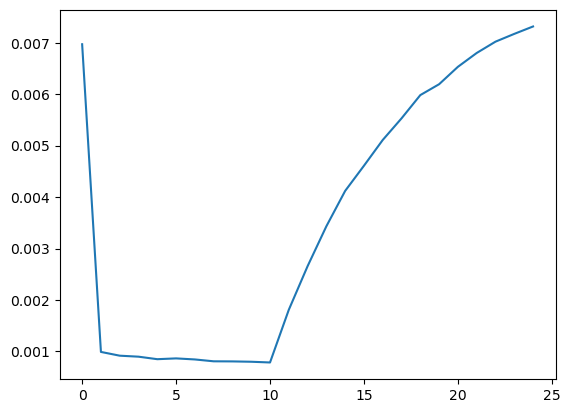

In [3]:
# plots training loss stuff
import matplotlib.pyplot as plt
plt.plot(range(len(training_losses)),training_losses)

In [5]:
batch_size = 32
imitation_train_dataset = ImitationDataLoader(video_name_list=video_list[0:6],batch_size=batch_size)
imitation_test_dataset = ImitationDataLoader(video_name_list=[video_list[6]],batch_size=batch_size)
pizzair_model = torch.load('models/pizzairnet_v1_checkpoint_24.pth')
pizzair_model.to(device)
pizzair_model.eval()
train_loss = 0.0
y_true = []
y_pred = []
with torch.inference_mode():
    for X_train_batch,Y_train_batch in tqdm(imitation_train_dataset,desc='Train'):
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        Y_train_hat = pizzair_model(X_train_batch)
        # adds relevant things
        #print(X_train_batch)
        print(Y_train_hat[0][0],Y_train_hat[1][0],Y_train_hat[2][0])
        #print(Y_train_batch[0][0],Y_train_batch[0][1],Y_train_batch[0][2])
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,50)
        #optimizer.step()
        train_loss += loss.item()
    print('Train Loss:',train_loss/(imitation_train_dataset.__len__()*batch_size))
    test_loss = 0.0

    for X_train_batch,Y_train_batch in tqdm(imitation_test_dataset,desc='Test'):
        # puts on GPU
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)

        Y_train_hat = pizzair_model(X_train_batch)
        #print(Y_train_hat)
        loss = pizzair_model.loss(Y_train_hat,Y_train_batch,50)
        test_loss += loss.item()
    print('Train Loss:',train_loss/(imitation_test_dataset.__len__()*batch_size))

Train:   0%|          | 2/776 [00:00<03:18,  3.91it/s]

tensor([0.2064], device='cuda:0') tensor([-0.9810,  0.3383, -0.0182], device='cuda:0') tensor([ 0.3444, -0.3872], device='cuda:0')
tensor([0.2720], device='cuda:0') tensor([-1.0419,  0.2859,  0.0720], device='cuda:0') tensor([ 0.2689, -0.3501], device='cuda:0')


Train:   1%|          | 5/776 [00:00<01:34,  8.14it/s]

tensor([0.1939], device='cuda:0') tensor([-1.8076,  0.8279, -0.5122], device='cuda:0') tensor([ 0.9645, -0.9741], device='cuda:0')
tensor([0.4775], device='cuda:0') tensor([-2.3411,  0.2113,  0.9756], device='cuda:0') tensor([ 0.0597, -0.0725], device='cuda:0')
tensor([0.1824], device='cuda:0') tensor([-1.2974,  0.4686, -0.0725], device='cuda:0') tensor([ 0.5018, -0.5086], device='cuda:0')
tensor([0.2458], device='cuda:0') tensor([-0.8475,  0.2955, -0.0396], device='cuda:0') tensor([ 0.2949, -0.3741], device='cuda:0')


Train:   1%|          | 8/776 [00:01<01:56,  6.57it/s]

tensor([0.2422], device='cuda:0') tensor([-0.5050,  0.3289, -0.3230], device='cuda:0') tensor([ 0.3671, -0.4895], device='cuda:0')
tensor([0.2426], device='cuda:0') tensor([-0.5461,  0.3272, -0.2944], device='cuda:0') tensor([ 0.3617, -0.4798], device='cuda:0')
tensor([0.2606], device='cuda:0') tensor([-0.3731,  0.2354, -0.2263], device='cuda:0') tensor([ 0.2472, -0.3859], device='cuda:0')


Train:   2%|▏         | 12/776 [00:01<01:14, 10.19it/s]

tensor([0.1318], device='cuda:0') tensor([-1.4554,  0.7546, -0.5244], device='cuda:0') tensor([ 0.8865, -0.8750], device='cuda:0')
tensor([0.1552], device='cuda:0') tensor([-1.2455,  0.8852, -1.0438], device='cuda:0') tensor([ 1.0927, -1.1474], device='cuda:0')
tensor([0.1112], device='cuda:0') tensor([-1.7689,  1.0378, -0.9003], device='cuda:0') tensor([ 1.2568, -1.2335], device='cuda:0')
tensor([0.1097], device='cuda:0') tensor([-1.6604,  1.0988, -1.1690], device='cuda:0') tensor([ 1.3562, -1.3570], device='cuda:0')


Train:   2%|▏         | 16/776 [00:01<01:03, 11.88it/s]

tensor([0.5963], device='cuda:0') tensor([-1.3833,  0.1220,  0.4470], device='cuda:0') tensor([ 0.0117, -0.2261], device='cuda:0')
tensor([0.1084], device='cuda:0') tensor([-1.7130,  1.0790, -1.0525], device='cuda:0') tensor([ 1.3211, -1.3096], device='cuda:0')
tensor([0.6799], device='cuda:0') tensor([-1.3353,  0.1195,  0.3632], device='cuda:0') tensor([ 0.0125, -0.2908], device='cuda:0')


Train:   2%|▏         | 18/776 [00:02<00:59, 12.76it/s]

tensor([0.2213], device='cuda:0') tensor([-0.1934,  0.2800, -0.3961], device='cuda:0') tensor([ 0.3213, -0.4546], device='cuda:0')
tensor([0.3078], device='cuda:0') tensor([-1.4542,  0.2972,  0.3055], device='cuda:0') tensor([ 0.2511, -0.2957], device='cuda:0')


Train:   2%|▏         | 18/776 [00:02<01:34,  8.02it/s]


Train Loss: 0.0008385883921459701


Test: 100%|██████████| 168/168 [00:10<00:00, 16.23it/s]

Train Loss: 0.003873479716102814


In [3]:
torch.save(pizzair_model,'models/pizzairnet_v1_1_0.pth')